In [1]:
wdir = "G:/My Drive/IntroDS_unitartu"

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from pmdarima import auto_arima, ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [22]:
%matplotlib inline

In [5]:
# change working directory
os.chdir(wdir)

In [6]:
train = pd.read_csv('data/train_cleaned.csv', parse_dates=['time'])
test = pd.read_csv('data/test_cleaned.csv', parse_dates=['time'])

In [8]:
# set time as index
train = train.set_index('time')
test = test.set_index('time')

In [9]:
train = train.asfreq('H')
test = test.asfreq('H')

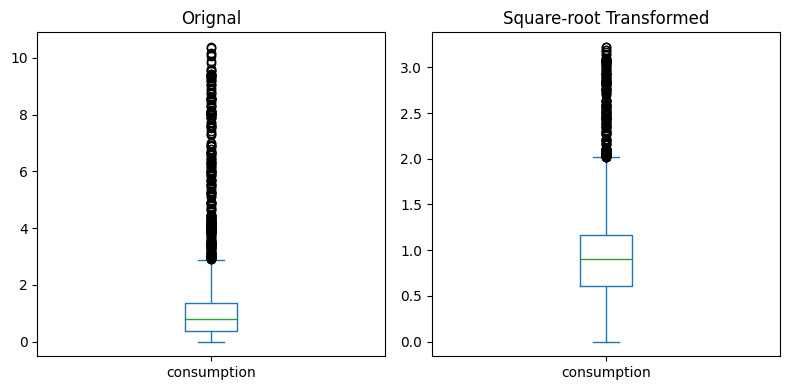

In [26]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
train.consumption.plot.box(ax=ax[0], title='Orignal')
train.consumption.apply(np.sqrt).plot.box(ax=ax[1], title='Square-root Transformed')
plt.tight_layout()
plt.show()

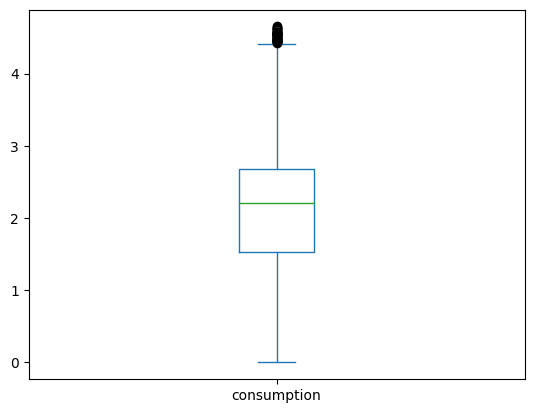

In [43]:
np.log1p(train.consumption*10).plot.box();

From above, the consumption distribution is not normally distributed both in its square root transformation. Multiplying the consumption by 10 and taking a natural logarithm of it makes it look almost normally distributed. We will use this method to see how the model will improve in performance

## Outline

In this notebook, we will build a forecasting model using ARIMA. This model will be used to forecast the hourly consumption of the household for the next 7 days.

Firstly, we will try to understand the consumption pattern:
- We will try to investigate if there are any trend or seaonality in the data. A trend and seasonal movement of consumption will affect the accuracy of our result, hence we need to remove them by making them stationary. The ADFuller test is used to determine if the data is stationary. A method of removing this non-stationarity in the data is by applying _differencing_, where we subtract previous value from next value. This is important for ARIMA model to factor that into its modelling. Differecing d, is one of the components in ARIMA.


- Next we will decompose our timeseries data into trends, seasonals, and residuals. We will use the _seasonal_decompose_ function to do that.


- Next we will investigate the autocorrelation and partial autocorrelation of hourly consumption. In time series modelling, we expect that the next record can be predicted by the record precedeing it (This is called _autocorrelation_). Also, we will also try to investigate how this autocorrelation changes with time, that is the difference between previous lags and the ones preceding it. This is termed _partial autocorrelation method_. These are important for us to determine the p,q values in ARIMA function. p stands for the autoregressive component while q stands for the moving average component. The p value is gotten from partial autocorrelation while the q value from autocorrelation.


- Next we will plot the autocorrelation and partial autocorrelation to determine lags that are significant.


- After that, we determine the p,d,q values and use them to build an ARIMA model.


- We will use the ARIMA and AutoARIMA functions in _pmdarima_ library. ARIMA can also be found in the _statsmodels_ library.

### Stationarity

> _H0_: It is non-stationary\
_H1_: It is stationary\
_$\alpha$_ = 0.05


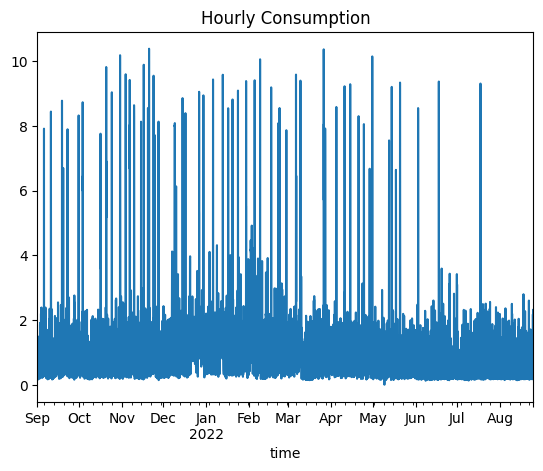

In [44]:
train.consumption.plot(title='Hourly Consumption')
plt.show()

We can also determine if our data is stationary by splitting the data into two and finding their mean and variances. If the mean and variance are close to each other, then our data is stationary.

In [12]:
split = len(train)//2
X1 = train.consumption[:split]
X2 = train.consumption[split:]

print(f'X1_mean : {X1.mean():.5f}, X2_mean: {X2.mean():.5f}')
print(f'X1_variance : {X1.var():.5f}, X2_variance: {X2.var():.5f}')

X1_mean : 1.24005, X2_mean: 0.85284
X1_variance : 1.50467, X2_variance: 0.81873


From the output above, we see that both are relatively equal to each other. Therefore, we think the data is stationary. However we will use the Augmented Dickey-Fuller (ADFuller) test to test that.

In [13]:
result = adfuller(train['consumption'])
print(f'ADF statistic: {result[0]}\np-value:{result[1]}')

ADF statistic: -11.365387004301915
p-value:9.254074322853303e-21


From the p-value, we see that it is lower than the $\alpha$, therefore we conclude that our data is stationary and hence, no differencing will need to be applied to our data.

### Autocorrelation and Partial Autocorrelation Plots

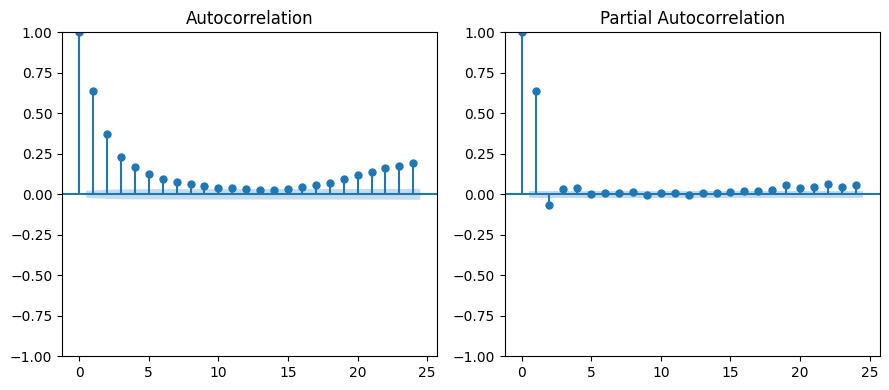

In [46]:
fig, ax = plt.subplots(1,2, figsize=(9,4))
plot_acf(train.consumption, ax=ax[0], lags=24)
plot_pacf(train.consumption, ax=ax[1], method='ywm', lags=24)
plt.tight_layout()
plt.show()

From the autocorrelation plot, we see that most of the records are correlated with each other, with the first lag with a correlation of 0.5 with the preceding data. This autocorrelation decrease with hours and begin to rise towards the end of the day (4PM-12AM). From the partial autocorrelation plot, we see that the autocorrelation of values decrease with time, with only the first lag having the most significance. 

We will use the _ndiff_ function from _pmdarima_ to use various stationarity tests to find an optimal differecing parameter to use. The tests include the adf (Augmented Dickey-Fuller), kpss (Kwiatkowski-Phillips-Schmidt-Shin), and pp (Phillips–Perron) test.

From the autocorrelation and partial autocorrelation plots, we can select p,q values to try and see which combinations will give the least error

In [15]:
## Adf Test
print(ndiffs(train.consumption, test='adf'), end=', ') 

# KPSS test
print(ndiffs(train.consumption, test='kpss'), end=', ')

# PP test:
print(ndiffs(train.consumption, test='pp'))

0, 1, 0


Using the different stationarity tests: adf, kpss and pp, we see that two of the tests suggested no differencing, while kpss suggested 1-differencing.

### Seasonal Decompose

Here, we want to find out if there's any seasonality in our data

In [55]:
decompose = seasonal_decompose(np.log1p(train.consumption*10), period=24) # 24 hours

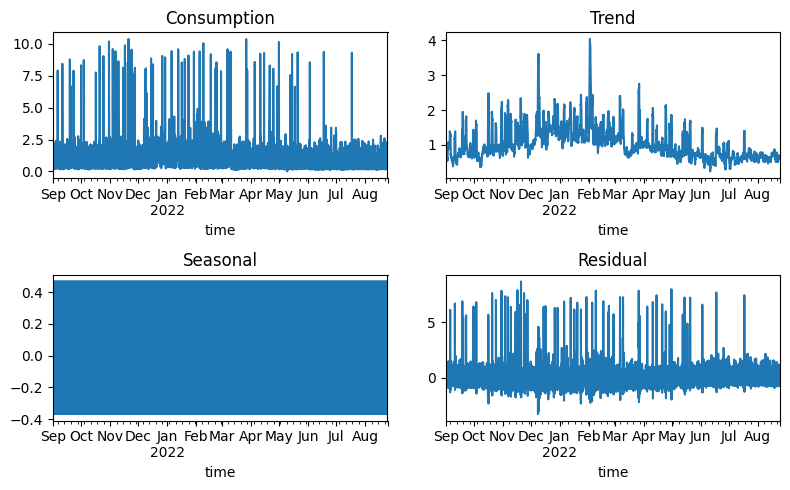

In [54]:
fig, ax = plt.subplots(2,2, figsize=(8,5))

decompose.observed.plot(ax=ax[0,0], title='Consumption')
decompose.trend.plot(ax=ax[0,1], title='Trend')
decompose.seasonal.plot(ax=ax[1,0], title='Seasonal')
decompose.resid.plot(ax=ax[1,1], title='Residual')
plt.tight_layout()
plt.show()

There seems to be no seasonality in our data

### ARIMA Modelling

For ARIMA modelling we will use the auto arima function from _pmdarima_ library. This will find the optimal p,d,q values for our data automatically.

In [56]:
X = train.drop(columns=['consumption', 'hour', 'weekday', 'week', 'month', 'coco'])
y = np.log1p(train.consumption*10)

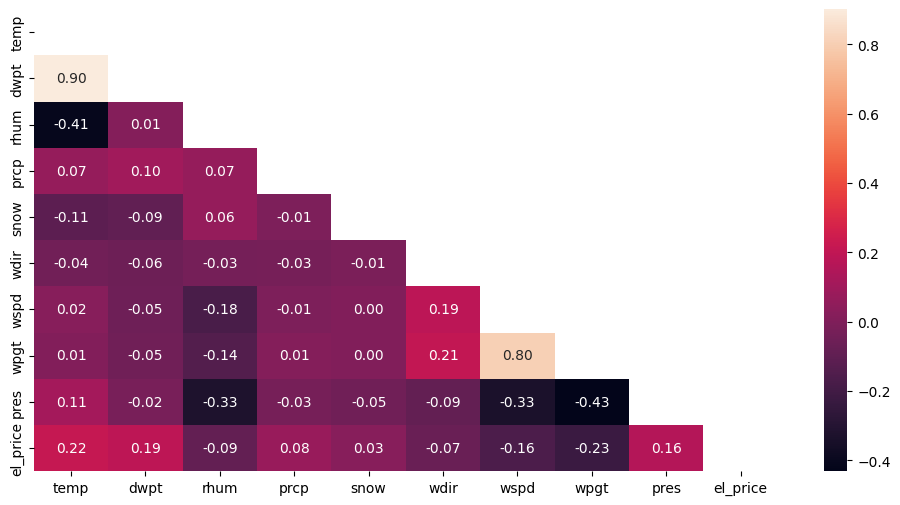

In [57]:
X_corr = X.corr()
plt.figure(figsize=(12,6))

sns.heatmap(X_corr, mask=np.triu(X_corr), annot=True, fmt='.2f')
plt.show()

In [ ]:
# fitting an automated ARIMA model to find optimal parameters
arima = auto_arima(y=y, X=X, start_p=1, start_q=1, test='adf', stationary=True, max_q=3, max_p=3)

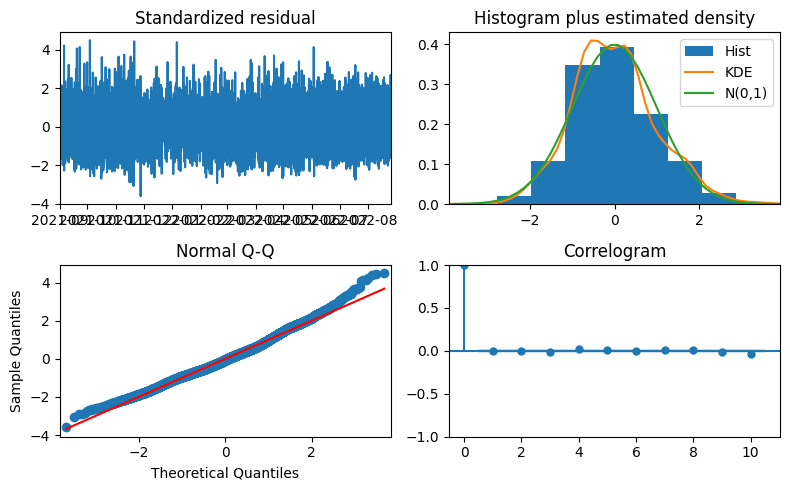

In [94]:
arima.plot_diagnostics(figsize=(8,5))
plt.tight_layout()
plt.show()

In [95]:
print(arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8592
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -7331.137
Date:                Sat, 03 Dec 2022   AIC                          14694.274
Time:                        01:11:15   BIC                          14807.212
Sample:                    09-01-2021   HQIC                         14732.793
                         - 08-24-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
temp           0.0500      0.015      3.272      0.001       0.020       0.080
dwpt          -0.0761      0.016     -4.802      0.000      -0.107      -0.045
rhum           0.0194      0.003      5.564      0.0

In [96]:
(np.expm1(arima.fittedvalues())/10).describe()

count    8592.000000
mean        0.860331
std         0.473417
min         0.044942
25%         0.502236
50%         0.775321
75%         1.089914
max         4.096044
dtype: float64

### Evaluation

In [97]:
def eval_metric(ytrue, ypred):
    ytrue = np.expm1(ytrue)/10
    ypred = np.expm1(ypred)/10
    mae = mean_absolute_error(ytrue, ypred)
    rmse= mean_squared_error(ytrue, ypred, squared=False)
    print(f'MAE: {mae:.4f}\tRMSE: {rmse:.4f}')

In [98]:
eval_metric(y, arima.fittedvalues())

MAE: 0.4861	RMSE: 0.9076


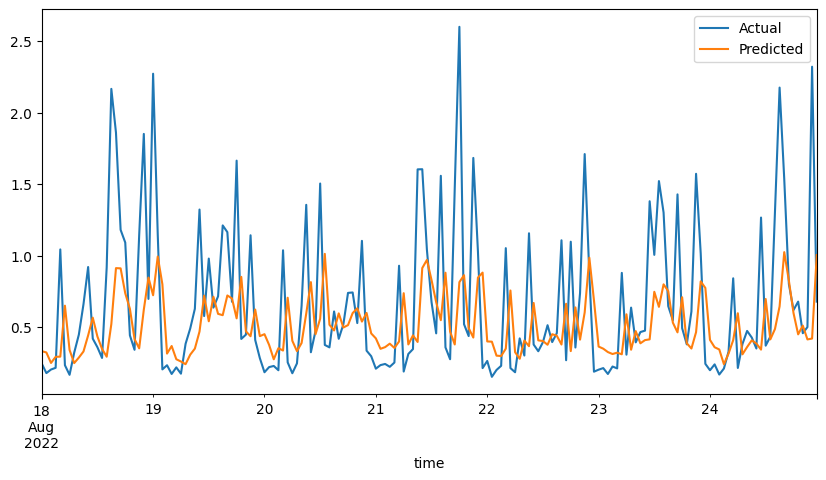

In [99]:
plt.figure(figsize=(10,5))
(np.expm1(y)/10)[-24*7:].plot(label='Actual')
(np.expm1(arima.fittedvalues())/10)[-24*7:].plot(label='Predicted')
plt.legend()
plt.show()

## Splitting into train and test sets.

We will split the train data into two: a new train data and test set. The test set will be used to evaluate its performance.
Test data will contain data for the last 7 days (ie 7*24).

In [100]:
train_1 = train[:-7*24]
val = train[-7*24:]

In [101]:
xtrain = train_1[X.columns]
ytrain = np.log1p(train_1.consumption*10)

xval = val[X.columns]
yval = np.log1p(val.consumption*10)

In [88]:
xtrain.shape, xval.shape

((8424, 10), (168, 10))

In [102]:
# fitting arima model to train data
model = auto_arima(ytrain, xtrain, start_p=1, start_q=1, test='adf', 
                   stationary=True, max_q=3, max_p=3)

In [103]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8424
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -7181.706
Date:                Sat, 03 Dec 2022   AIC                          14391.412
Time:                        01:26:48   BIC                          14489.955
Sample:                    09-01-2021   HQIC                         14425.054
                         - 08-17-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
temp           0.0391      0.016      2.516      0.012       0.009       0.070
dwpt          -0.0633      0.016     -3.928      0.000      -0.095      -0.032
rhum           0.0168      0.004      4.736      0.0

In [107]:
# reconvert to original values
train_preds = model.fittedvalues()
val_preds=  model.predict(n_periods=7*24, X=xval)

In [109]:
eval_metric(ytrain, train_preds)
eval_metric(yval, val_preds)

MAE: 0.4881	RMSE: 0.9152
MAE: 0.4359	RMSE: 0.6099


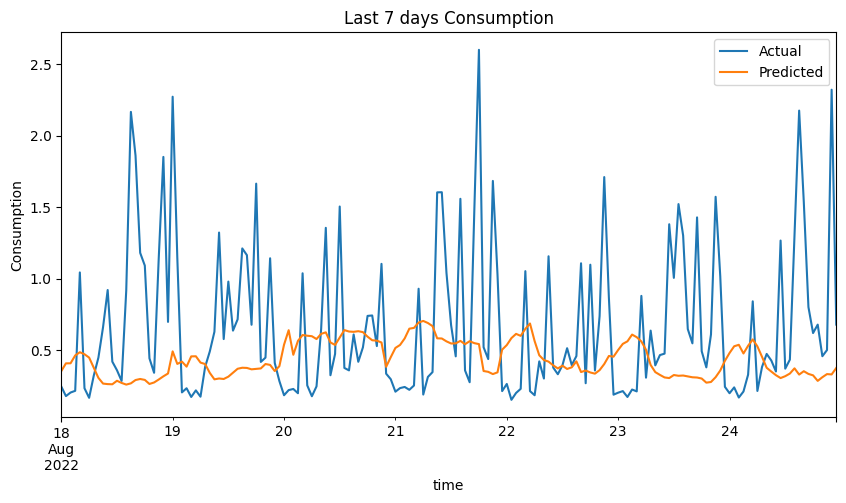

In [127]:
plt.figure(figsize=(10,5))
(np.expm1(y[-7*24:])/10).plot(label='Actual')
(np.expm1(val_preds)/10).plot(label='Predicted')
plt.title('Last 7 days Consumption')
plt.ylabel('Consumption')
plt.legend();

### Fitting on all data and predicting on test data

In [163]:
final_model = ARIMA(order=(3,0,2), stationary=True)

In [164]:
final_model.fit(y, X)

ARIMA(order=(3, 0, 2))

In [165]:
print(final_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8592
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -7331.092
Date:                Sat, 03 Dec 2022   AIC                          14696.183
Time:                        01:58:32   BIC                          14816.179
Sample:                    09-01-2021   HQIC                         14737.110
                         - 08-24-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.208      0.002      0.998      -0.407       0.408
temp           0.0500      0.016      3.164      0.002       0.019       0.081
dwpt          -0.0761      0.016     -4.682      0.0

In [166]:
# Get predictions and convert back to original values
predictions = np.expm1(final_model.predict(n_periods=24*7, X=test[X.columns]))/10

In [167]:
predictions.describe()

count    168.000000
mean       0.489890
std        0.127458
min        0.279809
25%        0.383020
50%        0.485647
75%        0.588758
max        0.842789
dtype: float64

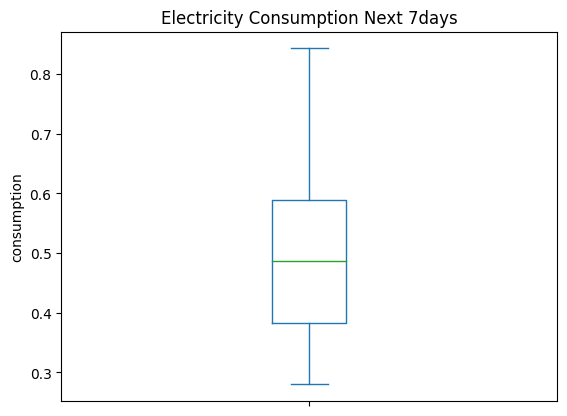

In [168]:
predictions.plot.box(ylabel='consumption', title='Electricity Consumption Next 7days');

In [169]:
preds = pd.DataFrame({'time':predictions.index, 'consumption':predictions.values})

In [170]:
preds.to_csv('arima.csv', index=False)